In [17]:
# import libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Import and process the data

In [18]:
# import dataset (comes with colab!)
data = pd.read_csv('train.csv')

# extract labels (number IDs) and remove from data
data.describe()
labels = data['label']
data   = data.drop('label',axis=1)
data.describe()
data = data.values
#data = np.where(data>127,255,0)#binarized

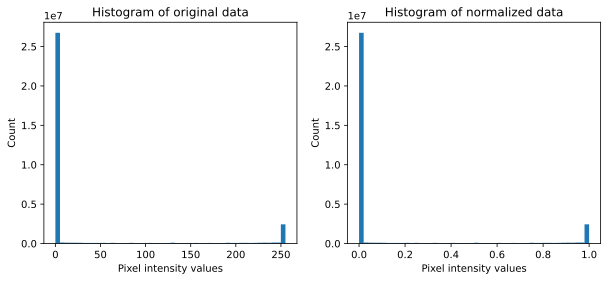

In [19]:
# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(data.flatten(),50)
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of original data')

ax[1].hist(dataNorm.flatten(),50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of normalized data')

plt.show()

# Create train/test groups using DataLoader

In [20]:
# Step 1: convert to tensor
dataT   = torch.tensor( data ).float()
labelsT = torch.tensor( labels.values ).long() # long = int64

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)

#Normalizing only train data
# train_data = train_data / np.max(data)

#normalizing only test_data
test_data = test_data / np.max(data)
# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [21]:
# check all variables in workspace
%whos

Variable                 Type             Data/Info
---------------------------------------------------
DataLoader               type             <class 'torch.utils.data.dataloader.DataLoader'>
F                        module           <module 'torch.nn.functio<...>/torch/nn/functional.py'>
TensorDataset            type             <class 'torch.utils.data.dataset.TensorDataset'>
X                        Tensor           tensor([[0., 0., 0.,  ...<...>, 0.,  ..., 0., 0., 0.]])
ax                       ndarray          2: 2 elems, type `object`, 16 bytes
batchsize                int              32
createTheMNISTNet        function         <function createTheMNISTNet at 0x177e50b80>
data                     ndarray          42000x784: 32928000 elems, type `int64`, 263424000 bytes (251.220703125 Mb)
dataNorm                 ndarray          42000x784: 32928000 elems, type `float64`, 263424000 bytes (251.220703125 Mb)
dataT                    Tensor           tensor([[0., 0., 0.,  ...<...

# Create the DL model

In [22]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)
      
      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return torch.log_softmax( self.output(x),axis=1 )
      # NEW HERE: log-softmax the output, because I'm using NLLLoss instead of CrossEntropyLoss
  
  # create the model instance
  net = mnistNet()
  
  # loss function
  lossfun = nn.NLLLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [23]:
# test the model with one batch
net,lossfun,optimizer = createTheMNISTNet()

X,y = next(iter(train_loader))
yHat = net(X)

# values are log-probability of each number (0-9)
# print(torch.exp(yHat))

# now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

 
Loss:
tensor(4.4839, grad_fn=<NllLossBackward0>)


# Create a function that trains the model

In [24]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 60
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


# Run the model and show the results!

In [25]:
trainAcc,testAcc,losses,net = function2trainTheModel()


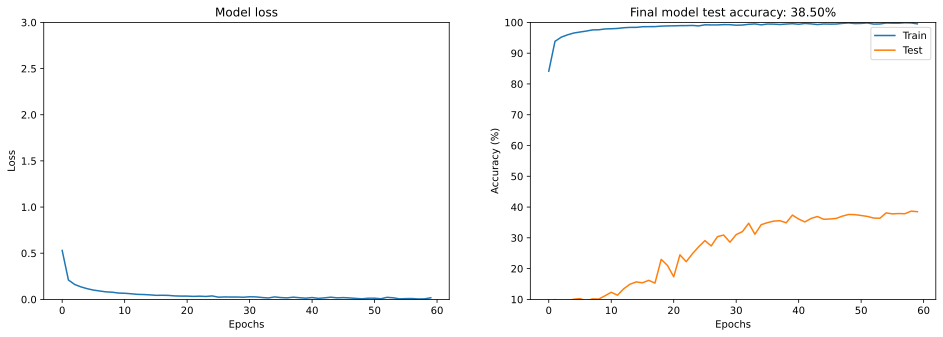

In [26]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

# Inspect the results in more detail

In [27]:
# run the model through for the test data
X,y = next(iter(test_loader))
predictions = net(X).detach()

predictions

tensor([[-2.6022, -2.1177, -2.2209,  ..., -2.3601, -2.1364, -2.1709],
        [-2.5533, -2.2574, -2.2001,  ..., -2.2045, -2.2112, -2.1392],
        [-2.5556, -2.1837, -2.1875,  ..., -2.3113, -2.1517, -2.1984],
        ...,
        [-2.5734, -2.1525, -2.2080,  ..., -2.3540, -2.1439, -2.1798],
        [-2.5786, -2.3494, -2.3049,  ..., -2.4045, -2.1189, -2.1420],
        [-2.6053, -2.2752, -2.1397,  ..., -2.2717, -2.1589, -2.1839]])

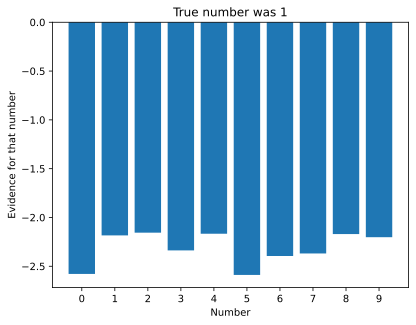

In [28]:
# Evidence for all numbers from one sample
sample2show = 120

plt.bar(range(10),predictions[sample2show]) # try adding exp!
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Evidence for that number')
plt.title('True number was %s' %y[sample2show].item())
plt.show()

In [29]:
errors = np.where( torch.max(predictions,axis=1)[1] != y )[0]
print(errors)

[   1    2    3 ... 4197 4198 4199]


[   1    2    3 ... 4197 4198 4199]


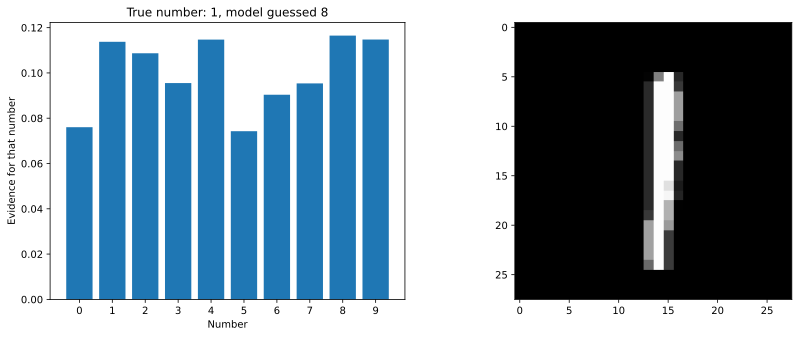

In [30]:
# find the errors
errors = np.where( torch.max(predictions,axis=1)[1] != y )[0]
print(errors)

# Evidence for all numbers from one sample
sample2show = 10

fig,ax = plt.subplots(1,2,figsize=(14,5))

ax[0].bar(range(10),np.exp(predictions[errors[sample2show]]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel('Number')
ax[0].set_ylabel('Evidence for that number')
ax[0].set_title('True number: %s, model guessed %s' 
                %( y[errors[sample2show]].item(), torch.argmax(predictions[errors[sample2show]]).item() ))

ax[1].imshow( np.reshape(X[errors[sample2show],:],(28,28)) ,cmap='gray')

plt.show()

In [31]:
print(y)
total7 = np.where(y==7)[0]
print(total7)
error7 =np.where(y[errors] == 7)[0]
print(y[errors[error7]])
pred_error = predictions[errors[error7]]

pred7 = torch.max(pred_error, axis=1)[1]
print(pred7)

tensor([1, 7, 1,  ..., 1, 5, 3])
[   1   11   21   56   78   85   86   94   99  110  115  119  121  126
  127  133  138  156  166  177  183  194  196  209  213  226  228  229
  233  249  269  270  275  278  285  290  293  298  305  315  325  330
  375  388  391  397  398  431  445  448  457  467  472  474  481  484
  498  512  533  538  561  575  584  587  596  605  607  611  613  614
  624  636  658  681  691  696  699  706  707  709  726  733  740  758
  764  788  791  794  797  818  842  849  852  879  881  887  889  891
  913  931  936  948  950  952  955  975  984  993  995  999 1012 1013
 1030 1032 1039 1074 1094 1103 1108 1117 1125 1153 1205 1209 1221 1227
 1248 1251 1252 1265 1268 1273 1279 1285 1287 1309 1329 1335 1356 1368
 1370 1375 1384 1397 1408 1413 1414 1424 1436 1439 1448 1458 1478 1485
 1495 1500 1501 1529 1533 1540 1542 1543 1552 1553 1574 1590 1591 1596
 1618 1622 1625 1632 1636 1637 1641 1648 1650 1656 1689 1700 1717 1720
 1740 1750 1758 1764 1778 1798 1800 1815 182

# Additional explorations

In [32]:
# 1) Average together the correct 7's and the error 7's, and make images of them (that is, one image
#    of all correct 7's and one image of all incorrectly labeled 7's). How do they look?
# 
# 2) Repeat #1 for all numbers to produce a 2x10 matrix of images with corrects on top
#    and errors on the bottom.
# 
# 3) Identify "almost errors," which we can define as correct categorizations that had a probability of
#    e.g., >.1 for any other number. Make images of some of these numbers. Can you understand why the model
#    was confused?
# 
# 4) I didn't use .train(), .eval(), or no_grad() here. Is that a problem? Can you add those in without checking
#    other notebooks?
# 